In [2]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [3]:
DATA_PATH = 'data/'
DATASET = 'merged_data_clean.csv'

df = pd.read_csv(DATA_PATH + DATASET)

In [4]:
# Scale Data

from sklearn.preprocessing import StandardScaler
numeric_data = df.select_dtypes(include=[float, int])
scaled_data = StandardScaler().fit_transform(numeric_data)
scaled_data.shape

(129, 102)

In [5]:
# Use Autoencoder to reduce dimensionality
num_dimensions = 10

encoder = keras.models.Sequential([
    keras.layers.Dense(25, activation="selu"),
    keras.layers.Dense(num_dimensions, activation="selu")
])

decoder = keras.models.Sequential([
    keras.layers.Dense(25, activation="selu", input_shape=[num_dimensions]),
    keras.layers.Dense(scaled_data.shape[1], activation="selu")
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(optimizer="adam", loss="mse")
autoencoder.fit(scaled_data, scaled_data, epochs=1000, validation_data=[scaled_data, scaled_data])

Epoch 1/1000
5/5 [==============================] - 2s 47ms/step - loss: 1.3569 - val_loss: 1.2079
Epoch 2/1000
5/5 [==============================] - 0s 10ms/step - loss: 1.1708 - val_loss: 1.0923
Epoch 3/1000
5/5 [==============================] - 0s 14ms/step - loss: 1.0701 - val_loss: 1.0128
Epoch 4/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.9908 - val_loss: 0.9401
Epoch 5/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.9201 - val_loss: 0.8682
Epoch 6/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.8463 - val_loss: 0.7976
Epoch 7/1000
5/5 [==============================] - 0s 12ms/step - loss: 0.7793 - val_loss: 0.7353
Epoch 8/1000
5/5 [==============================] - 0s 14ms/step - loss: 0.7169 - val_loss: 0.6843
Epoch 9/1000
5/5 [==============================] - 0s 13ms/step - loss: 0.6698 - val_loss: 0.6404
Epoch 10/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.6284 - val_loss: 0.6019
Epoch 11/

In [6]:
encoded_data = encoder.predict(scaled_data)

5/5 [==============================] - 0s 2ms/step


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.128s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 2.488650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.634003
[t-SNE] KL divergence after 300 iterations: 0.282434


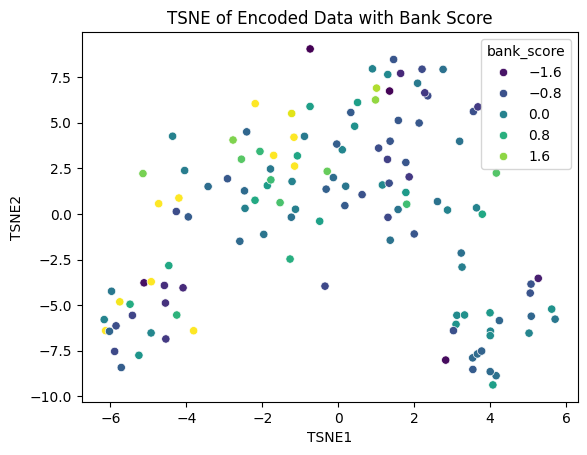

In [7]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results  = tsne.fit_transform(encoded_data)
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
score = df['Pounds of Food Distributed'] / df['Pop2010'] - df['PovertyRate']
q1 = score.quantile(0.25)
q3 = score.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr
score = score.clip(lower, upper)
tsne_df['bank_score'] = (score - score.mean()) / score.std()

plt.figure()
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="bank_score",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=tsne_df,
    legend="auto"
)

plt.title("TSNE of Encoded Data with Bank Score")
# plt.savefig('clustering.png')
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 129 samples in 0.000s...
[t-SNE] Computed neighbors for 129 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 129 / 129
[t-SNE] Mean sigma: 2.488650
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.393692
[t-SNE] KL divergence after 300 iterations: 0.269719


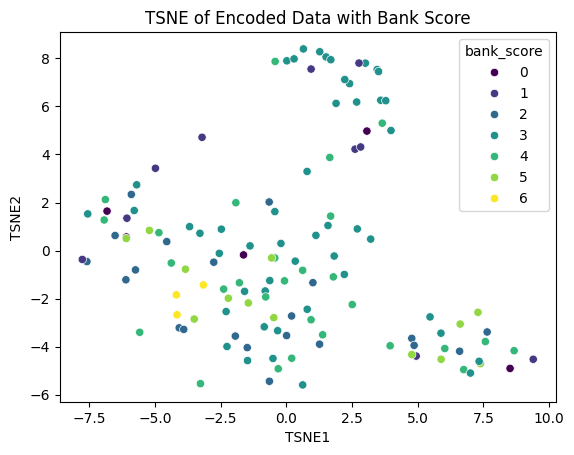

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results  = tsne.fit_transform(encoded_data)
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
score = df['Pounds of Food Distributed'] / df['TractLOWI']
min_score = np.min([val for val in score if val > 0.0])
imputed_score = np.array([min_score if val == 0.0 else val for val in score])
tsne_df['bank_score'] = pd.cut(np.log(imputed_score), bins=7, labels=False)

plt.figure()
sns.scatterplot(
    x="TSNE1", y="TSNE2",
    hue="bank_score",
    palette=sns.color_palette("viridis", as_cmap=True),
    data=tsne_df,
    legend="auto"
)

plt.title("TSNE of Encoded Data with Bank Score")
# plt.savefig('clustering.png')
plt.show()